# Iterative α-(de)Blending

Jax version of: https://github.com/tchambon/IADB

In [1]:
import jax
import optax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import urllib.request
import matplotlib.image as mpimg

from tqdm import tqdm
from numba import njit
from typing import Callable
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
@njit
def generate_samples_from_image(image, n_data):
    max_pdf_value = np.max(image)
    samples = np.zeros((n_data, 2))
    for n in range(n_data):
        while True:
            x, y, u = np.random.rand(3)
            i = int(x * image.shape[1])
            j = int(y * image.shape[2])
            
            if image[0, i, j, 0] / max_pdf_value >= u:
                samples[n, 0] = x
                samples[n, 1] = y
                break
    return samples

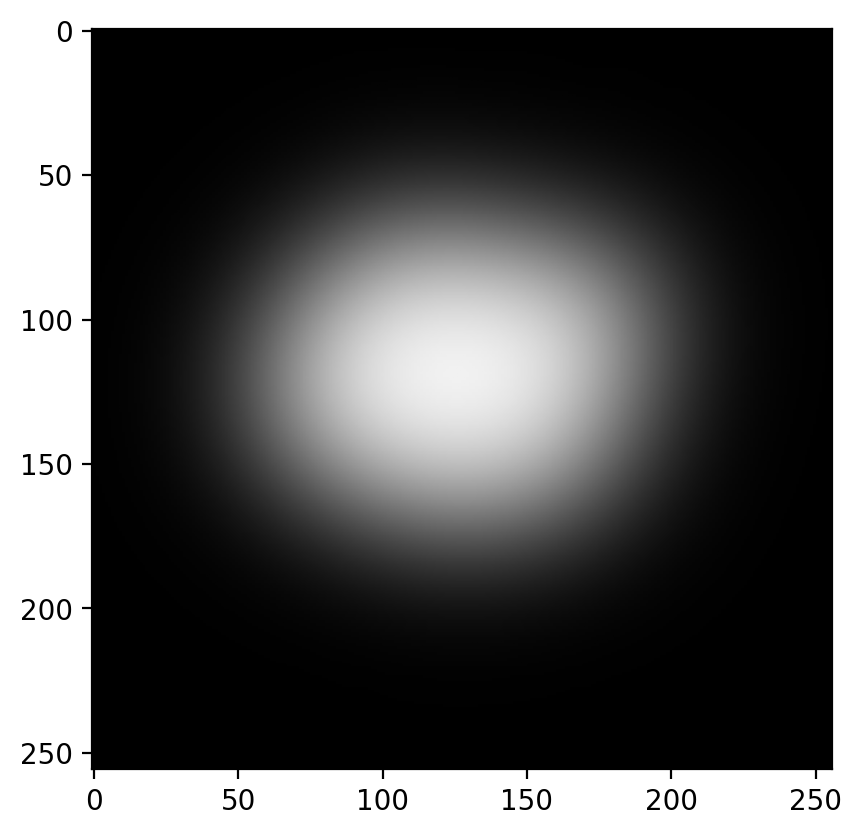

In [4]:
url = 'https://raw.githubusercontent.com/tchambon/posts/main/iadb-2D/images/p0.png'

urllib.request.urlretrieve(url, "p0.png")

p_0 = mpimg.imread('p0.png')
imgplot = plt.imshow(p_0)
plt.show()

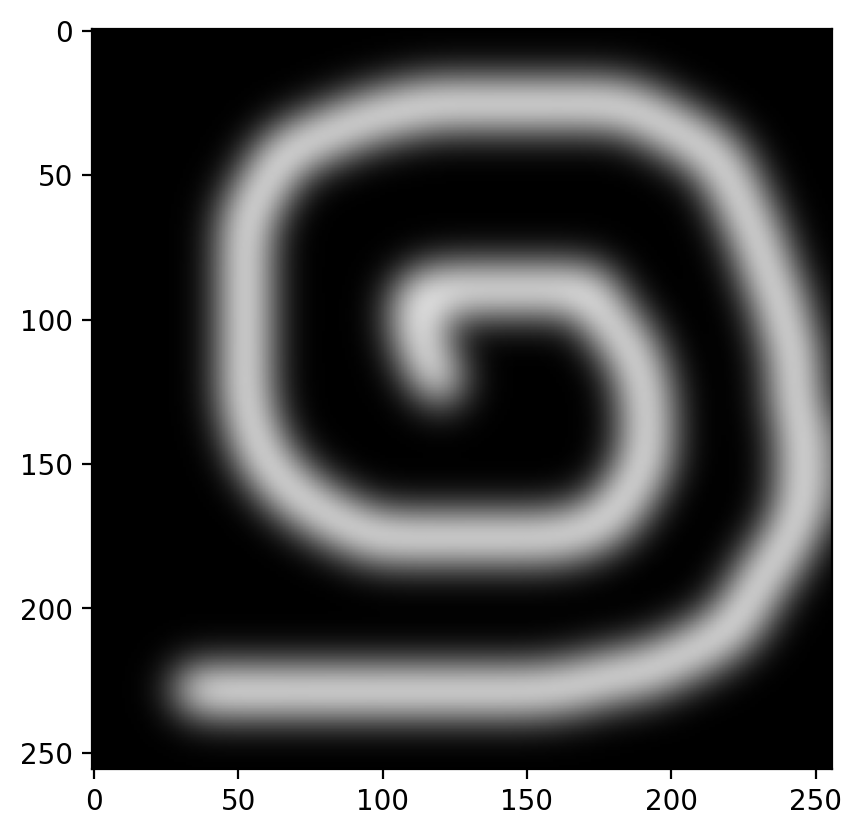

In [5]:
url = 'https://raw.githubusercontent.com/tchambon/posts/main/iadb-2D/images/p1.png'
urllib.request.urlretrieve(url, "p1.png")

p_1 = mpimg.imread('p1.png')
imgplot = plt.imshow(p_1)
plt.show()

In [6]:
%%time
n_data = 65536
x_0_data = generate_samples_from_image(p_0[None, ...], n_data)
x_1_data = generate_samples_from_image(p_1[None, ...], n_data)

CPU times: user 1.23 s, sys: 20.9 ms, total: 1.25 s
Wall time: 1.25 s


## Training

In [7]:
class NN(nn.Module):
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x, alpha):
        res = jnp.concatenate([x, alpha], axis=1)
        res = self.activation(nn.Dense(64)(res))
        res = self.activation(nn.Dense(64)(res))
        res = self.activation(nn.Dense(64)(res))
        res = self.activation(nn.Dense(64)(res))
        out = nn.Dense(2)(res)
        return out

In [8]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)
model = NN()
dim_in = 2
params_init = model.init(key_init, jnp.zeros((1, dim_in)), jnp.zeros((1, 1)))

jax.tree_map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (64,), 'kernel': (3, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_2': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_3': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_4': {'bias': (2,), 'kernel': (64, 2)}}}

In [9]:
batch_size = 256

def lossfn(params, key, applyfn):
    key_rows, key_alpha = jax.random.split(key)
    rows0, rows1 = jax.random.randint(key_rows, shape=(2, batch_size), minval=0, maxval=n_data)
    x0 = jnp.take(x_0_data, rows0, axis=0)
    x1 = jnp.take(x_1_data, rows1, axis=0)
    alpha = jax.random.uniform(key_alpha, (batch_size,1))
    
    x_alpha = (1 - alpha) * x0 + alpha * x1
    
    distance_hat = applyfn(params, x_alpha, alpha)
    distance = x1 - x0
    
    loss = jnp.power(distance_hat - distance, 2).sum()
    return loss

def stepfn(state, key):
    l, grads = jax.value_and_grad(lossfn)(state.params, key, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    return state, l

In [10]:
%%time

tx = optax.adam(0.001)
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=tx
)

n_epochs = n_data
keys_train = jax.random.split(key_train, n_epochs)
state_final, losses = jax.lax.scan(stepfn, state, keys_train)
losses = np.array(losses)

CPU times: user 2.05 s, sys: 0 ns, total: 2.05 s
Wall time: 5.54 s


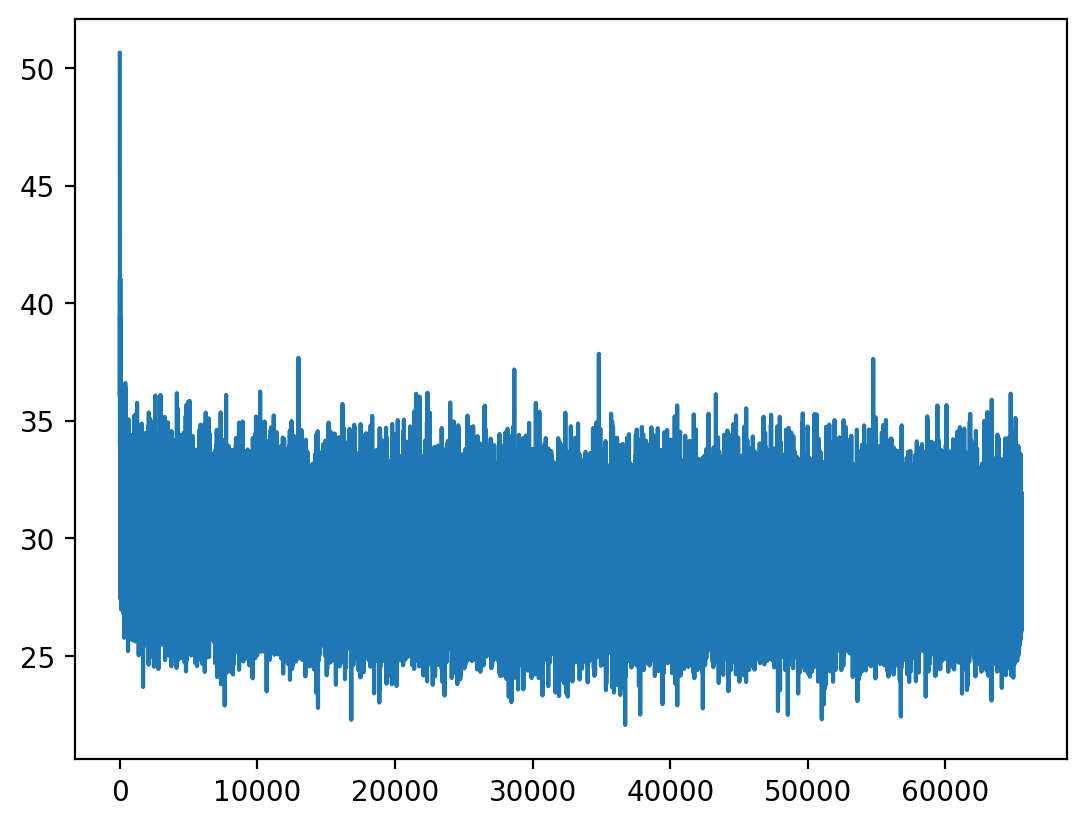

In [11]:
plt.plot(losses)

In [12]:
batchsize = 2048
x_alpha = x_0_data[np.random.randint(0, n_data, batchsize), :]
x_alpha = jnp.array(x_alpha)

# loop
T = 128
x_all = [x_alpha]
for t in tqdm(range(T), "sampling loop"):

    # current alpha value
    alpha = t / T * jnp.ones((batchsize, 1))

    # update
    x_alpha = x_alpha + 1/T * state_final.apply_fn(state_final.params, x_alpha, alpha)
    x_all.append(x_alpha)

sampling loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 44.17it/s]


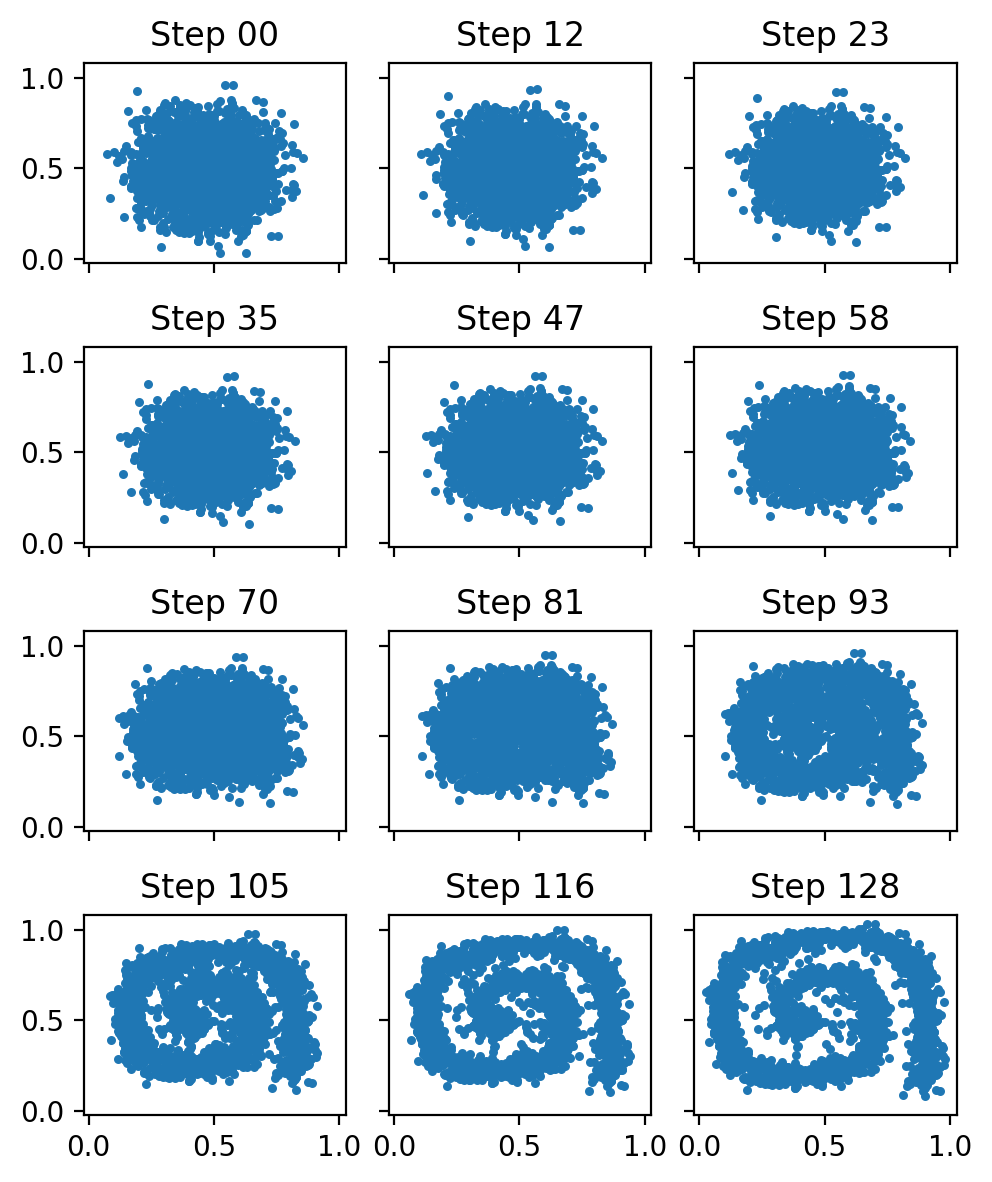

In [13]:
steps = np.linspace(0, T, 12).round().astype(int)

fig, axs = plt.subplots(4, 3, figsize=(5, 6.0), sharex=True, sharey=True)
for ax, s in zip(axs.ravel(), steps):
    ax.scatter(*x_all[s].T, s=5)
    ax.set_title(f"Step {s:02}")
plt.tight_layout()

### Animate!

In [14]:
from matplotlib import animation

MovieWriter ffmpeg unavailable; using Pillow instead.


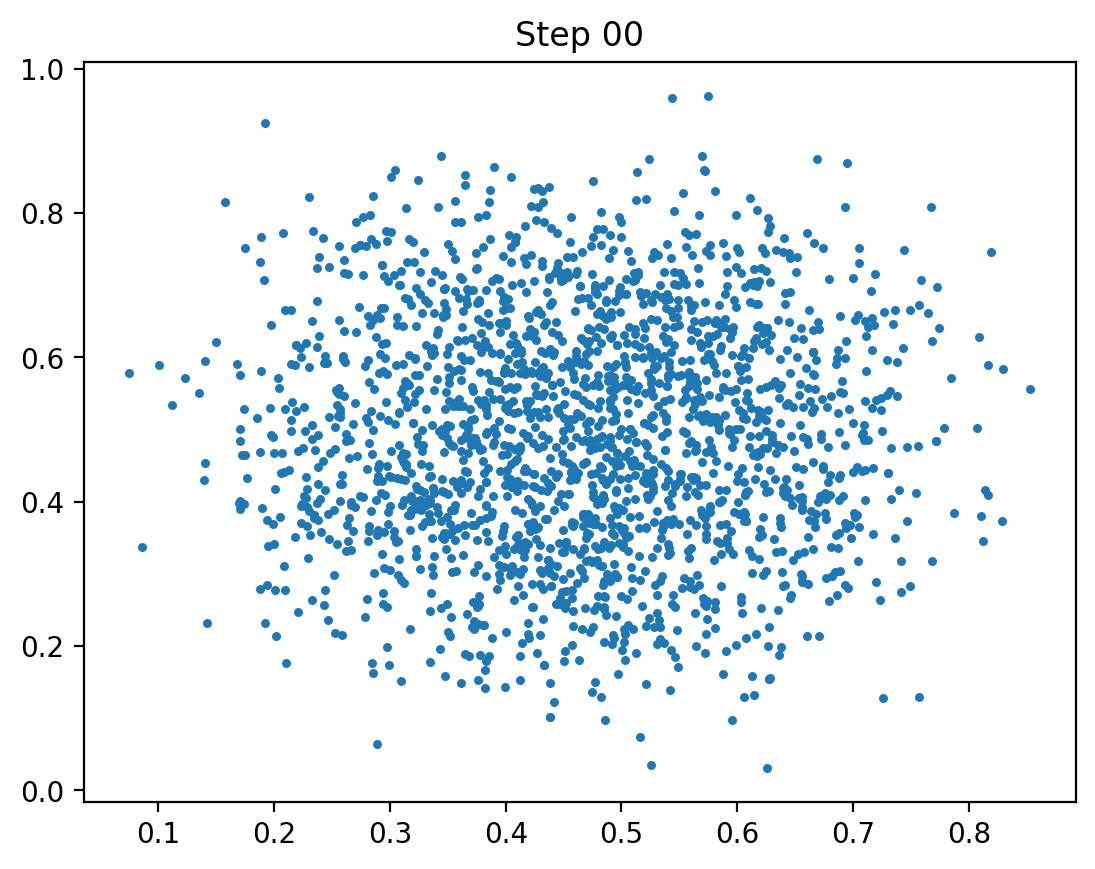

In [15]:
steps = np.arange(T)

fig, ax = plt.subplots()
def animate(t):
    ax.cla()
    ax.scatter(*x_all[t].T, s=5)
    ax.set_title(f"Step {t:02}")

ani = animation.FuncAnimation(fig, animate, steps)
ani.save("iadb.gif", fps=20)